### Loading a Data Subset
Load the data. Since the full dataset is large, the best practice is to start by creating a smaller, random subset to work with. This will make analysis and feature engineering much faster.

In [1]:
# Install the required libraries
# ! pip install -q wikihowunofficialapi textstat

In [2]:
import pandas as pd

# Load the full dataset from your .pickle file
full_data = pd.read_pickle('wikihow.pickle')

# Create a smaller, manageable subset of 1000 random articles for now
# Set a random_state so you get the same subset every time you run it
data = full_data.sample(n = 5000, random_state = 42)

In [3]:
print(f"Working with a subset of {len(data)} articles.")
data.head()

Working with a subset of 5000 articles.


,info
13225,How to Memorize Words for a Spelling Bee
10418,How to Discipline an Autistic Child
13346,How to Get out of a Nondisclosure Agreement
12239,How to Cope with Your Ex Dating Someone New
2641,How to Relieve School Anxiety for Special Need...


### Exploratory Data Analysis (EDA)
Before creating features, we need to understand the raw data. The code below will calculate some basic properties and visualize their distributions using histograms.

Starting data processing...
Data processing complete. New columns 'num_steps' and 'num_methods' are added.
Generating plots...


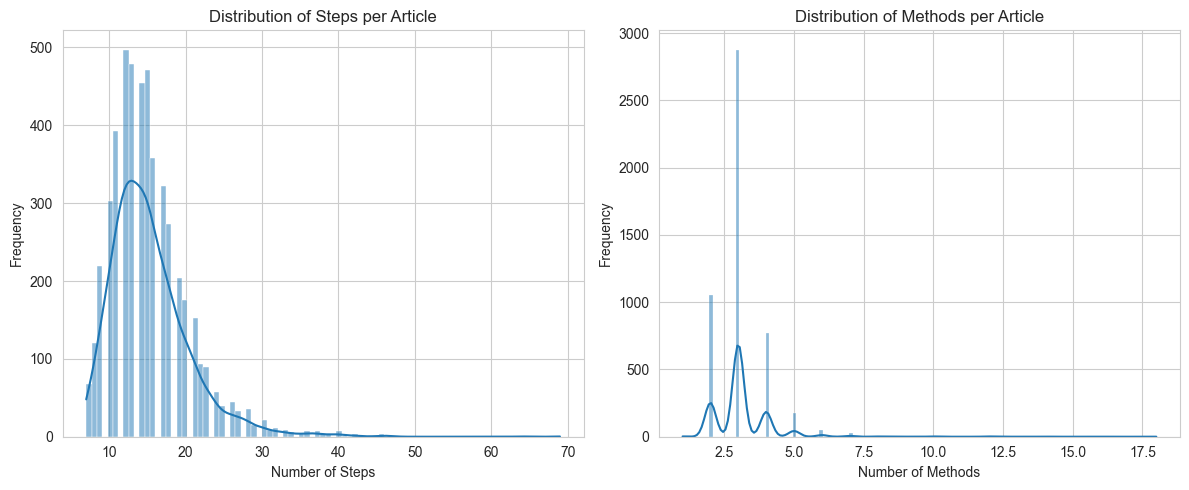

Plots generated successfully.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Processing Step ---
# Create lists to hold the metrics we calculate from each article.

print("Starting data processing...")
num_steps_list = []
num_methods_list = []

# Loop through each row in data subset
for index, row in data.iterrows():
    try:
        article = row['info']
        # Calculate total steps by summing steps in each method
        total_steps = sum(len(method.steps) for method in article.methods)
        
        num_steps_list.append(total_steps)
        num_methods_list.append(article.n_methods)
        
    except Exception as e:
        # If an article is malformed or causes an error, add 0.
        num_steps_list.append(0)
        num_methods_list.append(0)

# --- Column Creation Step ---
# Add the newly created lists as columns to the DataFrame.
data['num_steps'] = num_steps_list
data['num_methods'] = num_methods_list
print("Data processing complete. New columns 'num_steps' and 'num_methods' are added.")


# --- Plotting Step ---

print("Generating plots...")
sns.set_style("whitegrid")
plt.figure(figsize=(12, 5))

# Plot for 'num_steps'
plt.subplot(1, 2, 1)
sns.histplot(data['num_steps'], bins="auto", kde=True)
plt.title('Distribution of Steps per Article')
plt.xlabel('Number of Steps')
plt.ylabel('Frequency')

# Plot for 'num_methods'
plt.subplot(1, 2, 2)
sns.histplot(data['num_methods'], bins="auto", kde=True)
plt.title('Distribution of Methods per Article')
plt.xlabel('Number of Methods')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
print("Plots generated successfully.")

### Feature Engineering
The code below creates a function that extracts several features from each article and then applies it to the dataset. We will use the textstat library to automatically calculate readability scores.

In [5]:
import textstat # A library for calculating readability scores
import numpy as np # Import numpy for calculations

def create_features_enhanced(article):
    """
    This function takes a single wikiHow article object and returns a
    dictionary of enhanced features.
    """
    features = {}
    
    try:
        # 1. Initializing Structural Features (total number of methods, number of steps)
        features['num_methods'] = article.n_methods
        features['num_steps'] = sum(len(method.steps) for method in article.methods)

        # 2. Initializing Linguistic & Readability Features
        full_text = article.intro
        for method in article.methods:
            for step in method.steps:
                full_text += " " + step.description
        
        if not full_text.strip():
            return None

        # 3. Calculating text-based features (average sentence length, average word length, etc.)
        words = full_text.split()
        word_count = len(words)
        if word_count == 0:
            return None # Skip if there's no text
            
        features['word_count'] = word_count
        features['sentence_count'] = textstat.sentence_count(full_text)
        features['avg_sentence_length'] = np.mean([len(s.split()) for s in full_text.split('.')])
        features['avg_word_length'] = np.mean([len(w) for w in words])
        features['unique_word_count'] = len(set(words))
        features['num_warnings'] = len(article.warnings)
        features['num_tips'] = len(article.tips)

        # Readability scores from textstat
        features['flesch_reading_ease'] = textstat.flesch_reading_ease(full_text)
        features['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(full_text)

        # Avoid division by zero if num_methods is 0
        if features['num_methods'] > 0:
            features['avg_steps_per_method'] = features['num_steps'] / features['num_methods']
        else:
            features['avg_steps_per_method'] = 0
            
        return features

    except Exception as e:
        return None

# Apply the new function to your data
feature_list_enhanced = [create_features_enhanced(row['info']) for index, row in data.iterrows()]
features_df_enhanced = pd.DataFrame([f for f in feature_list_enhanced if f is not None])

features_df_enhanced.head()

,num_methods,num_steps,word_count,sentence_count,avg_sentence_length,avg_word_length,unique_word_count,num_warnings,num_tips,flesch_reading_ease,flesch_kincaid_grade,avg_steps_per_method
0,2,8,776,32,25.866667,4.481959,335,0,3,63.388776,10.442242,4.000000
1,6,40,4220,297,14.625430,4.775829,1414,3,4,68.961266,7.170466,6.666667
2,3,17,1767,128,13.194030,4.900396,632,0,0,57.533350,8.656286,5.666667
3,4,21,1632,133,13.064000,4.574142,654,1,2,77.433204,5.507329,5.250000
4,2,9,1827,78,23.126582,4.917898,628,0,1,52.105607,11.797847,4.500000


### Creating Target Variable (Complexity Score)
Now that we have our features (the inputs for the model), we need to create the target variable (the output the model will learn to predict). We'll create a composite score and then normalize it to be on a scale of 0 to 1.

In [6]:
from sklearn.preprocessing import MinMaxScaler

features_df_enhanced['complexity_score_raw'] = features_df_enhanced['num_steps'] + (features_df_enhanced['num_methods'] * 5)
scaler = MinMaxScaler()
features_df_enhanced['complexity_score'] = scaler.fit_transform(features_df_enhanced[['complexity_score_raw']])
features_df_enhanced = features_df_enhanced.drop(columns = ['complexity_score_raw'])

print("Enhanced DataFrame with more features:")
features_df_enhanced.head()

Enhanced DataFrame with more features:


,num_methods,num_steps,word_count,sentence_count,avg_sentence_length,avg_word_length,unique_word_count,num_warnings,num_tips,flesch_reading_ease,flesch_kincaid_grade,avg_steps_per_method,complexity_score
0,2,8,776,32,25.866667,4.481959,335,0,3,63.388776,10.442242,4.000000,0.049505
1,6,40,4220,297,14.625430,4.775829,1414,3,4,68.961266,7.170466,6.666667,0.564356
2,3,17,1767,128,13.194030,4.900396,632,0,0,57.533350,8.656286,5.666667,0.188119
3,4,21,1632,133,13.064000,4.574142,654,1,2,77.433204,5.507329,5.250000,0.277228
4,2,9,1827,78,23.126582,4.917898,628,0,1,52.105607,11.797847,4.500000,0.059406


### Training and Evaluating Models (Without Hyperparameter Tuning)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import math

# Using the feature-rich DataFrame created earlier
df_to_model = features_df_enhanced

# Defining our features (X) and target (Y)
X = df_to_model.drop(columns = ['complexity_score', 'num_steps', 'num_methods'])
y = df_to_model['complexity_score']

# Splitting data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"Training set has {X_train.shape[0]} samples.")
print(f"Testing set has {X_test.shape[0]} samples.")


# Training and evaluating the models (without hyperparameter tuning)
lr_model = LinearRegression()
print("\nTraining Linear Regression model...")
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_rmse = math.sqrt(mean_squared_error(y_test, lr_predictions))
print("Linear regression model training and testing complete.")
print(f"Linear Regression model RMSE: {lr_rmse:.4f}")

lasso_model = Lasso(random_state=42)
print("\nTraining Lasso Regression model...")
lasso_model.fit(X_train, y_train)
lasso_predictions = lasso_model.predict(X_test)
lasso_rmse = math.sqrt(mean_squared_error(y_test, lasso_predictions))
print("Lasso regression model training and testing complete.")
print(f"Lasso Regression model RMSE: {lasso_rmse:.4f}")

ridge_model = Ridge(random_state=42)
print("\nTraining Ridge Regression model...")
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)
ridge_rmse = math.sqrt(mean_squared_error(y_test, ridge_predictions))
print("Ridge regression model training and testing complete.")
print(f"Ridge Regression model RMSE: {ridge_rmse:.4f}")

rf_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
print("\nTraining Random Forest Regressor model...")
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_rmse = math.sqrt(mean_squared_error(y_test, rf_predictions))
print("Random Forest Regressor model training and testing complete.")
print(f"Random Forest Regressor model RMSE: {rf_rmse:.4f}")

gb_model = GradientBoostingRegressor(n_estimators = 100, random_state = 42)
print("\nTraining Gradient Boosting Regressor model...")
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
gb_rmse = math.sqrt(mean_squared_error(y_test, gb_predictions))
print("Gradient Boosting Regressor model training and testing complete.")
print(f"Gradient Boosting Regressor model RMSE: {gb_rmse:.4f}")


Training set has 4000 samples.
Testing set has 1000 samples.

Training Linear Regression model...
Linear regression model training and testing complete.
Linear Regression model RMSE: 0.0790

Training Lasso Regression model...
Lasso regression model training and testing complete.
Lasso Regression model RMSE: 0.0803

Training Ridge Regression model...
Ridge regression model training and testing complete.
Ridge Regression model RMSE: 0.0790

Training Random Forest Regressor model...
Random Forest Regressor model training and testing complete.
Random Forest Regressor model RMSE: 0.0660

Training Gradient Boosting Regressor model...
Gradient Boosting Regressor model training and testing complete.
Gradient Boosting Regressor model RMSE: 0.0663


### Random Forest Regressor Hyperparameter Tuning

In [8]:
from sklearn.model_selection import RandomizedSearchCV

# 1. Define the grid of hyperparameters to search
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 1.0]
}

# 2. Set up the Randomized Search
rf_model = RandomForestRegressor(random_state=42)
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=50, # Number of different combinations to try
    cv=5,      # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1 # Use all available CPU cores
)

# 3. Fit the search to the training data
print("Tuning hyperparameters for Random Forest...")
rf_random_search.fit(X_train, y_train)
print("Tuning complete.")

# 4. Get the best model and evaluate it
best_rf_model = rf_random_search.best_estimator_
rf_predictions = best_rf_model.predict(X_test)
rf_tuned_rmse = math.sqrt(mean_squared_error(y_test, rf_predictions))

print("\n--- Tuned Random Forest Results ---")
print(f"Best Hyperparameters: {rf_random_search.best_params_}")
print(f"Tuned Random Forest RMSE: {rf_tuned_rmse:.4f}")

Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Tuning complete.

--- Tuned Random Forest Results ---
Best Hyperparameters: {'n_estimators': 200, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': None}
Tuned Random Forest RMSE: 0.0677


### Gradient Boosting Regressor Hyperparameter Tuning

In [9]:
# 1. Define the grid of hyperparameters to search
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0]
}

# 2. Set up the Randomized Search
gb_model = GradientBoostingRegressor(random_state=42)
gb_random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=gb_param_grid,
    n_iter=50,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 3. Fit the search to the training data
print("\nTuning hyperparameters for Gradient Boosting...")
gb_random_search.fit(X_train, y_train)
print("Tuning complete.")

# 4. Get the best model and evaluate it
best_gb_model = gb_random_search.best_estimator_
gb_predictions = best_gb_model.predict(X_test)
gb_tuned_rmse = math.sqrt(mean_squared_error(y_test, gb_predictions))

print("\n--- Tuned Gradient Boosting Results ---")
print(f"Best Hyperparameters: {gb_random_search.best_params_}")
print(f"Tuned Gradient Boosting RMSE: {gb_tuned_rmse:.4f}")


Tuning hyperparameters for Gradient Boosting...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Tuning complete.

--- Tuned Gradient Boosting Results ---
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1}
Tuned Gradient Boosting RMSE: 0.0584


### Feature Importance Plot (For Random Forest and Gradient Boosting Models)

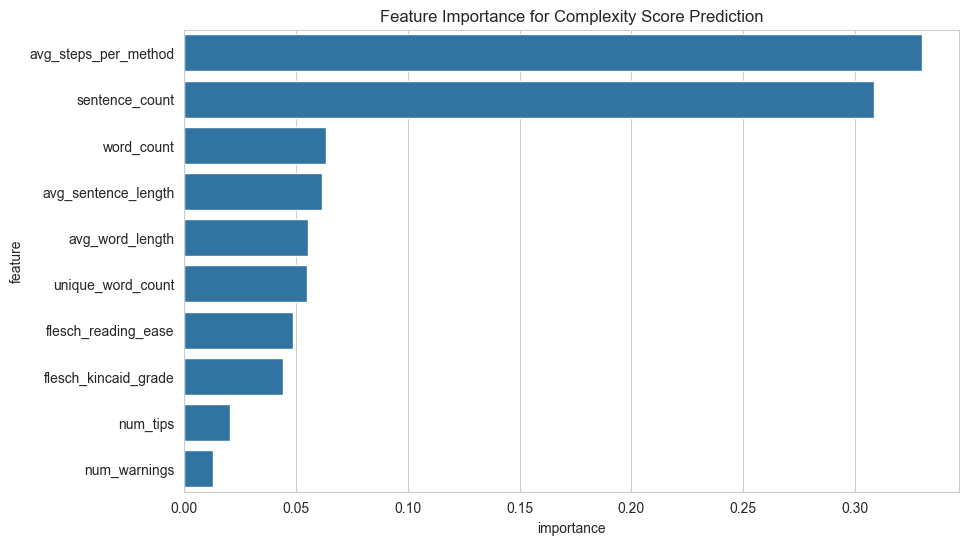

In [11]:
# Run this after the best model is trained
importances = best_gb_model.feature_importances_ # Or Random Forest model
feature_names = X.columns

importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance for Complexity Score Prediction')
plt.show()

### Actual vs. Predicted Scatter Plot

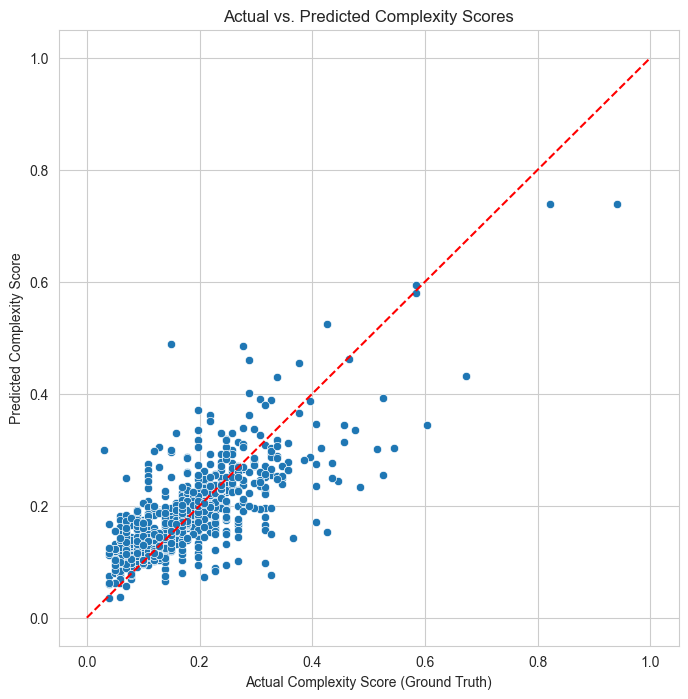

In [14]:
# Run this after you have made predictions on your test set (y_pred)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=gb_predictions)
plt.title('Actual vs. Predicted Complexity Scores')
plt.xlabel('Actual Complexity Score (Ground Truth)')
plt.ylabel('Predicted Complexity Score')
# Add a diagonal line for reference (a perfect model would have all points on this line)
plt.plot([0, 1], [0, 1], 'r--') 
plt.show()